## DeepSynergy

Author: Kristina Preuer

This Keras script shows how DeepSynergy was evaluated in one cross validation run (executed 5 times - looping over test folds). In this examples fold 0 is used for testing. The script uses 60% of the data  for training (folds 2, 3, 4) and 20% for validation (fold 1). The parameters are loaded with a separate text file (hyperparameters). Validation loss was used to determine the early stopping parameter. After hyperparameter selection the training and validation data was combined (80% = folds 1, 2, 3, 4) and the remaining 20% (fold 0) of the data were used for testing.

The original work was done accordingly with binet (https://github.com/bioinf-jku/binet/tree/master/binet). 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Temp/Help Ms. Giang/DRP4/drug_combination_rp/model/DeepSynergy/cv_example"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1QJBoPcJtlABBkDY6sNnS5-tui3RDBpOL/DRP4/drug_combination_rp/model/DeepSynergy/cv_example


In [ ]:
import os, sys

import pandas as pd
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import tensorflow.compat.v1.keras as K
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout

#### Define parameters for this cross-validation run

In [ ]:
data_name = "all_test"
hyperparameter_file = 'hyperparameters' # textfile which contains the hyperparameters of the model
data_file = f'{data_name}.pkl' # pickle file which contains the data (produced with normalize.ipynb)

#### Define smoothing functions for early stopping parameter

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Load parameters defining the model

In [ ]:
exec(open(hyperparameter_file).read())

#### Load data 
tr = 60% of data for training during hyperparameter selection <br>
val = 20% of data for validation during hyperparameter selection

train = tr + val = 80% of data for training during final testing <br>
test = remaining left out 20% of data for unbiased testing 

splitting and normalization was done with normalize.ipynb

In [ ]:
with open(data_file, "rb") as f:
    file = pickle.load(f)
train_dc, y_train, test_dc, y_test, val_dc, y_val, mix_val, y_mix_val,\
mix_test, y_mix_test, blind_cell_val, y_blind_cell_val,\
blind_cell_test, y_blind_cell_test, blind_1_drug_val, y_blind_1_drug_val,\
blind_1_drug_test, y_blind_1_drug_test, blind_1_drug_cell_val, y_blind_1_drug_cell_val,\
blind_1_drug_cell_test, y_blind_1_drug_cell_test, blind_2_drug_val, y_blind_2_drug_val,\
blind_2_drug_test, y_blind_2_drug_test, blind_all_val, y_blind_all_val,\
blind_all_test, y_blind_all_test = file
# train_dc, y_train, test_dc, y_test, val_dc, y_val = file

In [ ]:
print(train_dc.shape, y_train.shape)
print(val_dc.shape, y_val.shape)
print(test_dc.shape, y_test.shape)

(11512, 8486) (11512,)
(8964, 8486) (8964,)
(8968, 8486) (8968,)


#### run set

In [ ]:
config = tf.ConfigProto(
         allow_soft_placement=True,
         gpu_options = tf.GPUOptions(allow_growth=True))
set_session(tf.Session(config=config))

In [ ]:
train_dc

array([[ 0.99999503,  0.999247  ,  0.99999503, ...,  0.41752433,
        -0.82636706, -0.10128497],
       [ 0.99999503,  0.999247  ,  0.99999503, ..., -0.56403422,
        -0.86765309, -0.51576281],
       [ 0.99999503,  0.999247  ,  0.99999503, ...,  0.60702968,
         0.33929809, -0.85022873],
       ...,
       [-0.15374557, -0.24836659, -0.15374557, ...,  0.59945227,
        -0.87183932,  0.36570754],
       [-0.15374557, -0.24836659, -0.15374557, ..., -0.53197191,
        -0.27850797, -0.01489701],
       [-0.15374557, -0.24836659, -0.15374557, ..., -0.57263356,
         0.75276765, -0.9324907 ]])

In [ ]:
model = Sequential()
for i in range(len(layers)):
    if i==0:
        model.add(Dense(layers[i], input_shape=(train_dc.shape[1],), activation=act_func, 
                        kernel_initializer='he_normal'))
        model.add(Dropout(float(input_dropout)))
    elif i==len(layers)-1:
        model.add(Dense(layers[i], activation='linear', kernel_initializer="he_normal"))
    else:
        model.add(Dense(layers[i], activation=act_func, kernel_initializer="he_normal"))
        model.add(Dropout(float(dropout)))
    model.compile(loss='mean_squared_error', optimizer=K.optimizers.SGD(learning_rate=float(eta), momentum=0.5))

In [ ]:
model.history

#### run model for hyperparameter selection

In [ ]:
hist = model.fit(train_dc, y_train, epochs=epochs, shuffle=True, batch_size=64, validation_data=(val_dc, y_val))
val_loss = model.history.history['val_loss']
model.reset_states()

AttributeError: ignored

#### smooth validation loss for early stopping parameter determination

In [ ]:
average_over = 2
mov_av = moving_average(np.array(val_loss), average_over)
smooth_val_loss = np.pad(mov_av, int(average_over/2), mode='edge')
epo = np.argmin(smooth_val_loss)

#### determine model performance for methods comparison 

In [ ]:
# hist = model.fit(train_dc, y_train, epochs=epo, shuffle=True, batch_size=1024, validation_data=(val_dc, y_val))
test_loss = val_loss

#### plot performance 

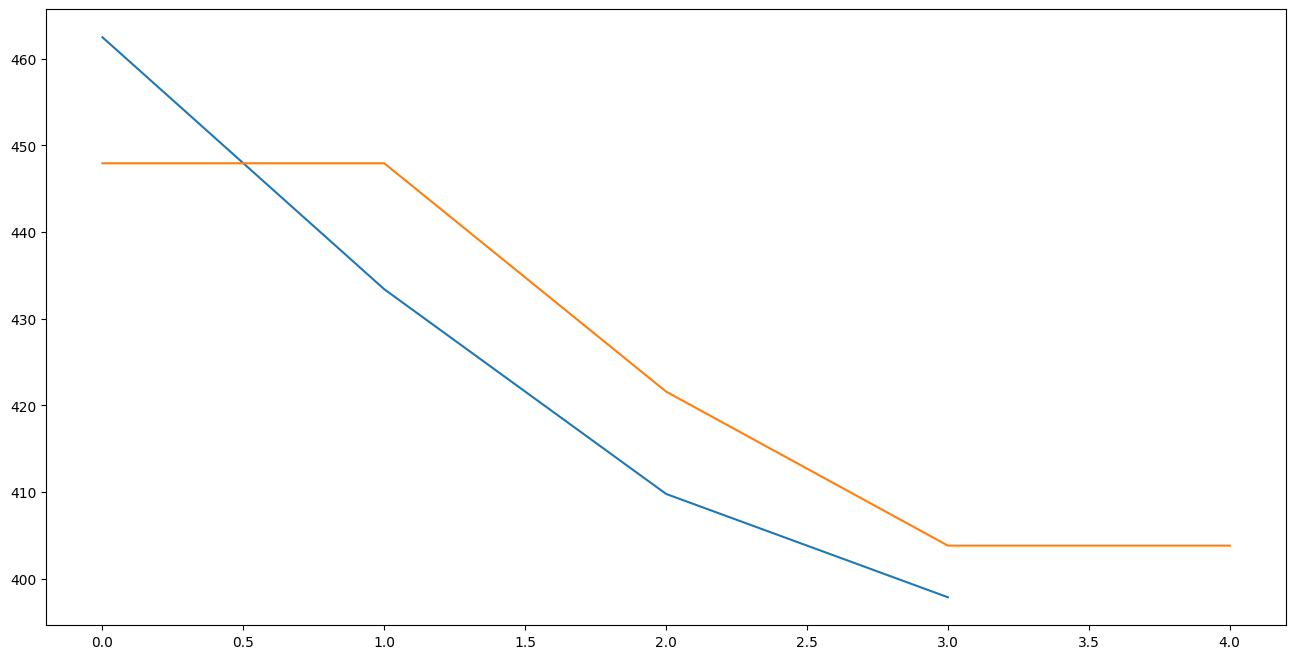

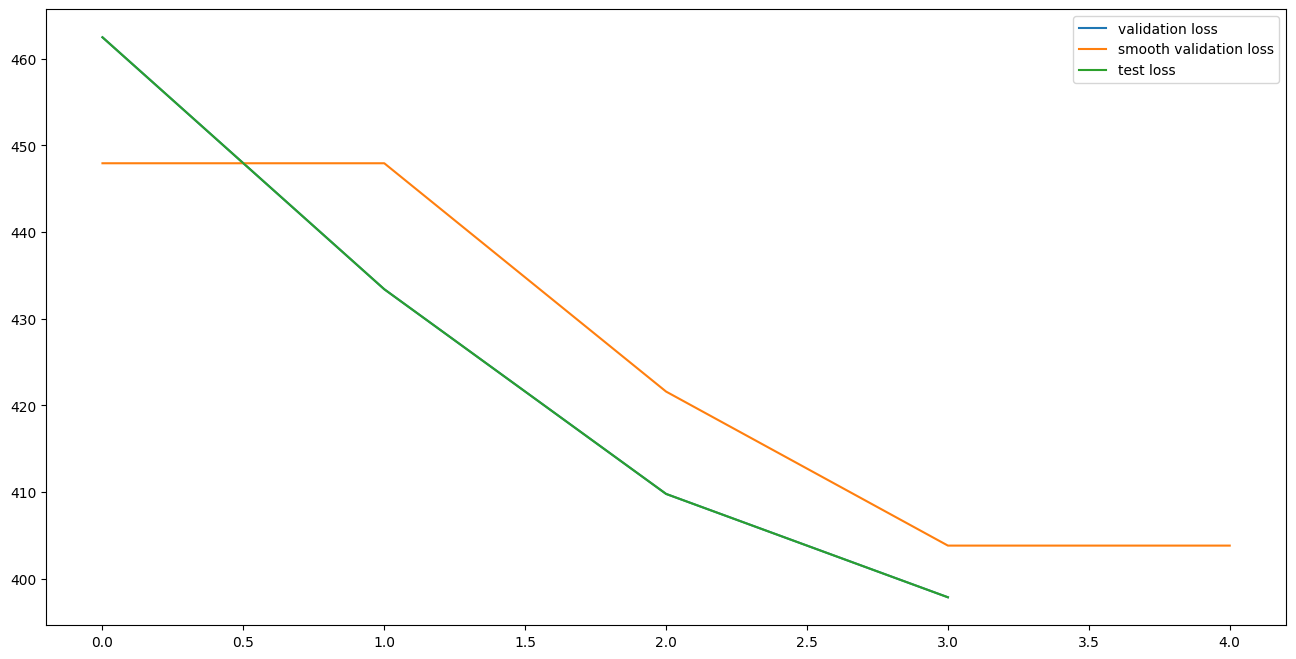

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(val_loss, label='validation loss')
ax.plot(smooth_val_loss, label='smooth validation loss')
ax.plot(test_loss, label='test loss')
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
def pearson(y,f):
    rp = np.corrcoef(y, f)[0,1]
    return rp
def evaluate_model(x, y):
    p = model.predict(x)
    rmse = np.sqrt(mean_squared_error(y, p))
    ccp = pearson(y, p)
    return rmse, ccp

In [ ]:
ret_test_save = evaluate_model(test_dc, y_test)
# ret_test_mix_dc_save = evaluate_model(mix_test, y_mix_test)
# ret_test_blind_cell_save = evaluate_model(blind_cell_test, y_blind_cell_test)
# ret_test_blind_1_drug_save = evaluate_model(blind_1_drug_test, y_blind_1_drug_test)
# ret_test_blind_1_drug_cell_save = evaluate_model(blind_1_drug_cell_test, y_blind_1_drug_cell_test)
# ret_test_blind_2_drug_save = evaluate_model(blind_2_drug_test, y_blind_2_drug_test)
# ret_test_blind_all_save = evaluate_model(blind_all_test, blind_all_test)

In [ ]:
result_file_name = 
with open(f"result_{data_name}.csv",'w') as f:
        f.write('ret_test: '+','.join(map(str,ret_test_save)) +"\n")
#         f.write('ret_mix_dc: '+','.join(map(str,ret_test_mix_dc_save)) +"\n")
#         f.write('ret_blind_cell: '+','.join(map(str,ret_test_blind_cell_save)) +"\n")
#         f.write('ret_blind_1_drug: '+','.join(map(str,ret_test_blind_1_drug_save)) +"\n")
#         f.write('ret_blind_1_drug_cell: '+','.join(map(str,ret_test_blind_1_drug_cell_save)) +"\n")
#         f.write('ret_blind_2_drug: '+','.join(map(str,ret_test_blind_2_drug_save)) +"\n")
#         f.write('ret_blind_all: '+','.join(map(str,ret_test_blind_all_save)) +"\n")